In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1' 
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/genre-100x100/test_data_genre.pkl
/kaggle/input/genre-100x100/train_data_genre.pkl
/kaggle/input/genre-100x100/valid_data_genre.pkl
/kaggle/input/best4-artists/train_data_artist_best4.pkl
/kaggle/input/best4-artists/valid_data_artist_best4.pkl
/kaggle/input/best4-artists/test_data_artist_best4.pkl
/kaggle/input/artists/test_data_artist_reduced224.pkl
/kaggle/input/artists/train_data_artist_reduced224.pkl
/kaggle/input/artists/valid_data_artist_reduced224.pkl
/kaggle/input/alexnet/pytorch/default/1/_model_7.pt


In [2]:
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
!pip install torchsummary
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image
from torch.utils.data import DataLoader, IterableDataset
from torchvision import transforms

import copy


In [3]:
class StreamWikiArtDataset(IterableDataset):

        def __init__(self, dataset, indices, class_to_idx, transform=None):
            self.dataset = dataset
            self.indices = indices
            self.transform = transform
            # self.length = len(indices)
            self.class_to_idx = class_to_idx
            self.classes = set()



        def __len__(self):
            return len(self.indices)

        def __iter__(self):
            print("Starting iteration...")
            dataset_iter = iter(self.dataset)


            for idx, item in enumerate(dataset_iter):

                if idx not in self.indices:
                  continue

                image = item['image']
                label = self.class_to_idx[item['artist']]
                self.classes.add(label)

                if self.transform:
                    image = self.transform(image)
                yield image, label


        def get_classes(self):
            return list(self.classes)


In [4]:
def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)

    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''

    start = time.time()
    history = []
    best_loss = 100000.0
    best_epoch = None

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))

        # Set to training mode
        model.train()

        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0

        valid_loss = 0.0
        valid_acc = 0.0

        for i, (inputs, labels) in enumerate(train_loader):

            inputs = inputs.to(device)
#             labels = labels - 1
#             assert labels.min().item() >= 0 and labels.max().item() < num_classes, "Adjusted labels are out of range"
            
            labels = labels.to(device)
#             print("Batch Labels:", labels)
            
            # Clean existing gradients
            optimizer.zero_grad()

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Backpropagate the gradients
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)

            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)

            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))


        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(valid_loader):
                inputs = inputs.to(device)
#                 labels = labels - 1
#                 assert labels.min().item() >= 0 and labels.max().item() < num_classes, "Adjusted labels are out of range"

                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_epoch = epoch

        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/valid_data_size
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])

        epoch_end = time.time()

        print("Epoch : {:03d}, Training: Loss - {:.4f}, Accuracy - {:.4f}%, \n\t\tValidation : Loss - {:.4f}, Accuracy - {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))

        # Save if the model has best accuracy till now
        torch.save(model, '_model_'+str(epoch)+'.pt')

    return model, history, best_epoch

In [5]:
# function to predict images and display the accuracy
def visualize_predictions(model, dataset,class_names):
    labels = []
    predictions = []
    acc = 0
    was_training = model.training
    model.eval()
    with torch.no_grad():
        dataset_iter = iter(dataset)
        for image, label in dataset_iter:
            image = image.unsqueeze(0)  # Add batch dimension
            image = image.to(device)
            output = model(image)
            _, preds = torch.max(output, 1)
            if class_names[label] == class_names[preds.item()]:
                acc += 1
            labels.append(class_names[label])
            predictions.append(class_names[preds.item()])
    print('Test Accuracy: {:.4f}'.format(acc/len(dataset)))
    model.train(mode=was_training)
    return labels, predictions

In [6]:
from torch.utils.data import DataLoader, IterableDataset
from torchvision import transforms
import pickle

# !pip install datasets

# Load the dataset objects
with open('/kaggle/input/best4-artists/train_data_artist_best4.pkl', 'rb') as f:
    train_data = pickle.load(f)

with open('/kaggle/input/best4-artists/valid_data_artist_best4.pkl', 'rb') as f:
    valid_data = pickle.load(f)

with open('/kaggle/input/best4-artists/test_data_artist_best4.pkl', 'rb') as f:
    test_data = pickle.load(f)
# # Load the dataset
# train_data = torch.load('/content/save_dataset.pth')

# # Create DataLoader objects again
train_loader = DataLoader(train_data, batch_size=16, shuffle=False)
valid_loader = DataLoader(valid_data, batch_size=16, shuffle=False)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

In [7]:
# Calculate the sizes of the datasets
train_data_size = len(train_data)
valid_data_size = len(valid_data)
test_data_size = len(test_data)

print("Train data size:", train_data_size)
print("Validation data size:", valid_data_size)
print("Test data size:", test_data_size)

Train data size: 3865
Validation data size: 1288
Test data size: 1289


In [10]:
model = torch.load("/kaggle/input/alexnet/pytorch/default/1/_model_7.pt")

In [11]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load pretrained ResNet50 Model
resnet50 = models.resnet50(pretrained=True)
resnet50 = resnet50.to(device)

# Freeze model parameters
for param in resnet50.parameters():
    param.requires_grad = False


# Change the final layer of resnet16 Model for Transfer Learning
fc_inputs = resnet50.fc.in_features

num_classes = 4
# resnet16.fc = torch.nn.Linear(fc_inputs, len(class_names))
resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, num_classes), # Since 10 possible outputs
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)



# Convert model to be used on GPU
resnet50 = resnet50.to(device)

# Define Optimizer and Loss Function
loss_func = nn.NLLLoss()
optimizer = optim.Adam(resnet50.parameters(), lr = 0.00001)

# model summary
summary(resnet50, (3, 224, 224), 32)

In [ ]:
# Train the model for 25 epochs
num_epochs = 7
trained_model, history, best_epoch = train_and_validate(resnet50, loss_func, optimizer, num_epochs)

torch.save(history, 'artist_history.pt')

In [ ]:
# history

In [ ]:
history = np.array(history)

# Plot training and validation accuracy
plt.plot(history[:, 2], label='Train Accuracy')
plt.plot(history[:, 3], label='Val Accuracy')
plt.legend(['Train Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

In [ ]:
class_names = list(range(4))

labels, predictions = visualize_predictions(resnet50, test_data, class_names)

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda:0


In [12]:

# Load pretrained ResNet50 Model
alexnet = models.alexnet(pretrained=True)
alexnet = alexnet.to(device)

# Freeze model parameters
for param in alexnet.parameters():
    param.requires_grad = False


# Change the final layer of resnet16 Model for Transfer Learning
# fc_inputs = alexnet.fc.in_features

num_classes = 4
# resnet16.fc = torch.nn.Linear(fc_inputs, len(class_names))
alexnet.classifier[6] = nn.Sequential(
    nn.Linear(alexnet.classifier[6].in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, num_classes), # Since 10 possible outputs
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)



# Convert model to be used on GPU
alexnet = alexnet.to(device)

# Define Optimizer and Loss Function
loss_func = nn.NLLLoss()
optimizer = optim.Adam(alexnet.parameters(), lr = 0.00001)

# model summary
summary(alexnet, (3, 224, 224), 32)

Using device: cuda:0


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 149MB/s]  


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 64, 55, 55]          23,296
              ReLU-2           [32, 64, 55, 55]               0
         MaxPool2d-3           [32, 64, 27, 27]               0
            Conv2d-4          [32, 192, 27, 27]         307,392
              ReLU-5          [32, 192, 27, 27]               0
         MaxPool2d-6          [32, 192, 13, 13]               0
            Conv2d-7          [32, 384, 13, 13]         663,936
              ReLU-8          [32, 384, 13, 13]               0
            Conv2d-9          [32, 256, 13, 13]         884,992
             ReLU-10          [32, 256, 13, 13]               0
           Conv2d-11          [32, 256, 13, 13]         590,080
             ReLU-12          [32, 256, 13, 13]               0
        MaxPool2d-13            [32, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [32, 25

In [13]:
# Train the model for 25 epochs
num_epochs = 8
trained_model, history, best_epoch = train_and_validate(alexnet, loss_func, optimizer, num_epochs)

torch.save(history, 'artist_history.pt')

Epoch: 1/8
Starting iteration...
Starting iteration...
Epoch : 000, Training: Loss - 1.1021, Accuracy - 58.4735%, 
		Validation : Loss - 0.8056, Accuracy - 76.1646%, Time: 3244.9888s
Epoch: 2/8
Starting iteration...
Starting iteration...
Epoch : 001, Training: Loss - 0.7513, Accuracy - 75.6274%, 
		Validation : Loss - 0.6094, Accuracy - 80.3571%, Time: 3077.1702s
Epoch: 3/8
Starting iteration...
Starting iteration...
Epoch : 002, Training: Loss - 0.6146, Accuracy - 78.2406%, 
		Validation : Loss - 0.5180, Accuracy - 82.3758%, Time: 3111.7144s
Epoch: 4/8
Starting iteration...
Starting iteration...
Epoch : 003, Training: Loss - 0.5435, Accuracy - 80.7245%, 
		Validation : Loss - 0.4659, Accuracy - 83.7733%, Time: 3126.9412s
Epoch: 5/8
Starting iteration...
Starting iteration...


'(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: 47fcc687-3c18-46b1-ba9f-27b286db557d)')' thrown while requesting GET https://huggingface.co/datasets/huggan/wikiart/resolve/d559852d2b232e0fcf195e775866964f0564f2b5/data/train-00021-of-00072.parquet
Retrying in 1s [Retry 1/5].


Epoch : 004, Training: Loss - 0.5017, Accuracy - 82.0957%, 
		Validation : Loss - 0.4345, Accuracy - 84.6273%, Time: 3106.1289s
Epoch: 6/8
Starting iteration...
Starting iteration...


'(ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: cd29d9a2-bd03-4f63-98ca-052b73b6e61a)')' thrown while requesting GET https://huggingface.co/datasets/huggan/wikiart/resolve/d559852d2b232e0fcf195e775866964f0564f2b5/data/train-00004-of-00072.parquet
Retrying in 1s [Retry 1/5].


Epoch : 005, Training: Loss - 0.4569, Accuracy - 83.6223%, 
		Validation : Loss - 0.4107, Accuracy - 85.7143%, Time: 3195.0436s
Epoch: 7/8
Starting iteration...
Starting iteration...
Epoch : 006, Training: Loss - 0.4390, Accuracy - 84.1397%, 
		Validation : Loss - 0.3925, Accuracy - 86.1801%, Time: 3153.3062s
Epoch: 8/8
Starting iteration...
Starting iteration...
Epoch : 007, Training: Loss - 0.4221, Accuracy - 84.5019%, 
		Validation : Loss - 0.3786, Accuracy - 86.8012%, Time: 3163.4108s


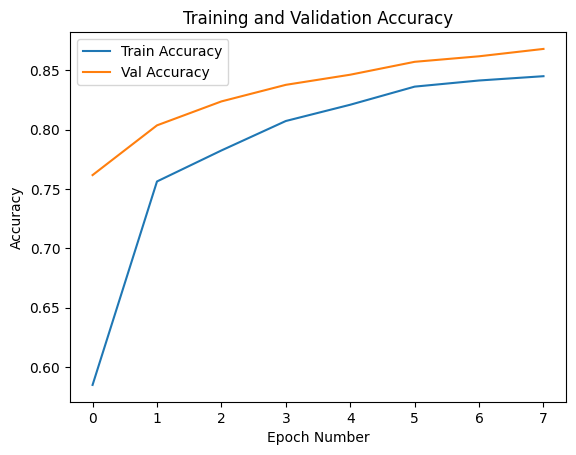

In [14]:
history = np.array(history)

# Plot training and validation accuracy
plt.plot(history[:, 2], label='Train Accuracy')
plt.plot(history[:, 3], label='Val Accuracy')
plt.legend(['Train Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

In [15]:
class_names = list(range(4))

labels, predictions = visualize_predictions(alexnet, test_data, class_names)

Starting iteration...
Test Accuracy: 0.8689


In [13]:
class_names = list(range(4))
class_names

[0, 1, 2, 3]

In [12]:
def all_predictions_per_class(model, dataset, class_names, device):
    class_correct = {class_name: 0 for class_name in class_names}
    class_total = {class_name: 0 for class_name in class_names}
    labels = []
    predictions = []
    acc = 0
    was_training = model.training
    model.eval()

    with torch.no_grad():
        for input, label in dataset:  # Using the iterator of IterableDataset
            input = input.unsqueeze(0)  # Add batch dimension
            input = input.to(device)
            output = model(input)
            _, preds = torch.max(output, 1)

            if class_names[label] == class_names[preds.item()]:
                acc += 1
                class_correct[class_names[label]] += 1

            class_total[class_names[label]] += 1

            labels.append(class_names[label])
            predictions.append(class_names[preds.item()])

    print('Test Accuracy: {:.4f}'.format(acc / sum(class_total.values())))

    for class_name in class_names:
        accuracy = class_correct[class_name] / class_total[class_name] if class_total[class_name] > 0 else 0
        print('Accuracy for {}: {:.4f}'.format(class_name, accuracy))

    model.train(mode=was_training)
    return labels, predictions


In [16]:
labels, predictions = all_predictions_per_class(model, test_data, class_names, device)

Starting iteration...
Test Accuracy: 0.8689
Accuracy for 0: 0.8750
Accuracy for 1: 0.8913
Accuracy for 2: 0.8705
Accuracy for 3: 0.8291
